#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, roc_auc_score,precision_score,accuracy_score,roc_curve,make_scorer
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,record_id
0,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,...,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0,453246940
1,3725.0,36 months,6.03,113.38,A,A1,NaN,NaN,MORTGAGE,52260.0,...,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0,453313687
2,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,...,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0,453283543
3,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,...,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0,453447199
4,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,...,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,453350283


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* loan_amnt  - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* installment - The monthly payment owed by the borrower if the loan originates.
* home_ownership    
* emp_title                   
* annual_inc                  
* verification_status  - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
* purpose                 
* dti -  A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* open_acc                  
* total_acc                    
* initial_list_status - The initial listing status of the loan. Possible values are – W, F           
* collections_12_mths_ex_med - Number of collections in 12 months excluding medical collections
* application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers
* acc_now_delinq - The number of accounts on which the borrower is now delinquent.


## Начальная обработка данных:

In [4]:
def Nan_killer(x):
    x['collections_12_mths_ex_med'] = x['collections_12_mths_ex_med'].fillna(0)
    x['revol_util'] = x['revol_util'].fillna(0)
    x['tot_coll_amt'] = x['tot_coll_amt'].fillna(0)


In [5]:
def proc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
    x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
    x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
    x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
    x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
    x_train = pd.get_dummies(x_train, columns = ['purpose','grade','home_ownership'])   # OHE (?????)
    x_test = pd.get_dummies(x_test, columns = ['purpose','grade','home_ownership'])
    for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
        if i not in list(x_train):
            list(my_dataframe)
            x_test.drop(i, axis=1, inplace=True)
    for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
        if i not in list(x_test):
            x_test[i] = 0
    

    x_test = x_test.reindex(sorted(x_test.columns), axis=1)
    x_train = x_train.reindex(sorted(x_test.columns), axis=1)
    return x_train, x_test, y_train, y_test

## Функция для отображения метрик:
* ROC-AUC
* precision
* recall
* accuracy

In [6]:

def show_scores(model, x_test, y_test):
    pred =  model.predict(x_test)
    print('Recall: %.2f' % recall_score(y_test,pred))
    print('Precision score: %.2f' % precision_score(y_test,pred))
    print('Accuracy score: %.2f' % accuracy_score(y_test, pred))
 

In [7]:
def plot_roc(model, x_test, y_test):  
    pred = model.predict_proba(x_test)
    print("ROC-AUC score: ", roc_auc_score(y_test, pred[:, 1]))
    fpr, tpr,_=roc_curve(y_test,pred[:, 1],drop_intermediate=True)
    plt.figure()
    plt.plot(fpr, tpr, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

# Регрессия

In [38]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

In [39]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','loan_status',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc                    200189 non-null float64
collections_12_mths_ex_med    200145 non-null float64
initial_list_status           200189 non-null object
installment                   200189 non-null float64
open_acc                      200189 non-null float64
total_acc                     200189 non-null float64
dti                           200189 non-null float64
purpose                       200189 non-null object
grade                         200189 non-null object
home_ownership                200189 non-null object
inq_last_6mths                200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    200035 non-null float64
loan_status                   200189 non-null int64
tot_coll_amt                  152232 non-null float64
loan_amnt                     2

In [40]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc                    200189 non-null float64
collections_12_mths_ex_med    200189 non-null float64
initial_list_status           200189 non-null object
installment                   200189 non-null float64
open_acc                      200189 non-null float64
total_acc                     200189 non-null float64
dti                           200189 non-null float64
purpose                       200189 non-null object
grade                         200189 non-null object
home_ownership                200189 non-null object
inq_last_6mths                200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    200189 non-null float64
loan_status                   200189 non-null int64
tot_coll_amt                  200189 non-null float64
loan_amnt                     2

In [41]:
x.nunique()

annual_inc                    16284
collections_12_mths_ex_med        7
initial_list_status               2
installment                   41347
open_acc                         58
total_acc                       105
dti                            3975
purpose                          14
grade                             7
home_ownership                    6
inq_last_6mths                    9
pub_rec                          13
revol_bal                     44045
revol_util                     1180
loan_status                       2
tot_coll_amt                   3646
loan_amnt                      1317
application_type                  2
acc_now_delinq                    6
dtype: int64

In [42]:
x_train, x_test, y_train, y_test = proc(x,y)

In [43]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null int64
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-nul

In [44]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 8644 to 191094
Data columns (total 43 columns):
acc_now_delinq                60057 non-null float64
annual_inc                    60057 non-null float64
application_type              60057 non-null int64
collections_12_mths_ex_med    60057 non-null float64
dti                           60057 non-null float64
grade_A                       60057 non-null uint8
grade_B                       60057 non-null uint8
grade_C                       60057 non-null uint8
grade_D                       60057 non-null uint8
grade_E                       60057 non-null uint8
grade_F                       60057 non-null uint8
grade_G                       60057 non-null uint8
home_ownership_ANY            60057 non-null int64
home_ownership_MORTGAGE       60057 non-null uint8
home_ownership_NONE           60057 non-null uint8
home_ownership_OTHER          60057 non-null uint8
home_ownership_OWN            60057 non-null uint8
home_ownersh

## Линейная регрессия  + Дерево решений (регрессия)

In [15]:
lm = linear_model.Lasso(alpha=0.01,random_state = 42).fit(x_train,y_train)
dec_reg = DecisionTreeRegressor(criterion='mse',max_depth=10, random_state=42, min_samples_leaf = 3).fit(x_train,y_train)

In [16]:
from sklearn.metrics import r2_score

In [17]:
r2_score(y_test, lm.predict(x_test))

0.9146765103292894

In [18]:
r2_score(y_test, dec_reg.predict(x_test))

0.9280174951473175

# Бинарная классификация

In [8]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','int_rate','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths',
                 'pub_rec','revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc                    200189 non-null float64
int_rate                      200189 non-null float64
collections_12_mths_ex_med    200145 non-null float64
initial_list_status           200189 non-null object
installment                   200189 non-null float64
open_acc                      200189 non-null float64
total_acc                     200189 non-null float64
dti                           200189 non-null float64
purpose                       200189 non-null object
grade                         200189 non-null object
home_ownership                200189 non-null object
inq_last_6mths                200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    200035 non-null float64
tot_coll_amt                  152232 non-null float64
loan_amnt                    

In [9]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc                    200189 non-null float64
int_rate                      200189 non-null float64
collections_12_mths_ex_med    200189 non-null float64
initial_list_status           200189 non-null object
installment                   200189 non-null float64
open_acc                      200189 non-null float64
total_acc                     200189 non-null float64
dti                           200189 non-null float64
purpose                       200189 non-null object
grade                         200189 non-null object
home_ownership                200189 non-null object
inq_last_6mths                200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    200189 non-null float64
tot_coll_amt                  200189 non-null float64
loan_amnt                    

In [10]:
x_train, x_test, y_train, y_test = proc(x,y)

In [11]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null bool
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-null

In [12]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null bool
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-null

## Логистическая регрессия

In [24]:
from sklearn import linear_model

In [25]:
lr = linear_model.LogisticRegression(solver='liblinear',random_state=42).fit(x_train, y_train)
lr.predict(x_test)
show_scores(lr, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


ROC-AUC score:  0.5877202844814491


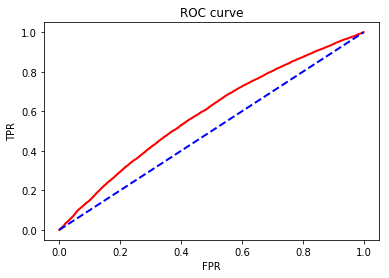

In [26]:
plot_roc(lr, x_test, y_test)

## Дерево решений (классификация)

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
clf_tree = DecisionTreeClassifier(criterion='entropy',splitter = 'random', max_depth=12, random_state=42, min_samples_leaf = 3)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

In [29]:
show_scores(clf_tree, x_test, y_test)

Recall: 0.97
Precision score: 0.79
Accuracy score: 0.77


ROC-AUC score:  0.6742598095246735


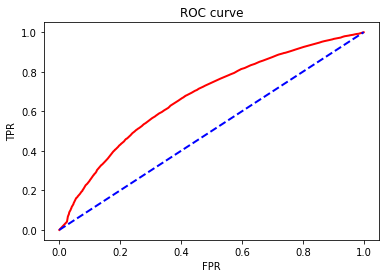

In [30]:
plot_roc(clf_tree, x_test, y_test)

## Случайный лес

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [32]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [12,10,8],
#    'min_samples_leaf': [1,3,5,7],
#    'n_estimators': [80,100,200,500],
#    'criterion' : ['entropy','gini'],
#}
#score = make_scorer(roc_auc_score)
#rf =  RandomForestClassifier(random_state = 42)
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 5, n_jobs = -1, verbose = 2, scoring=score)
#grid_search.fit(x_train,  y_train)
#grid_search.best_params_
# best_grid = grid_search.best_estimator_

In [33]:
best_grid = RandomForestClassifier(random_state = 42, bootstrap = True, 
                                   max_depth = 12, min_samples_leaf = 1,
                                   n_estimators = 80, criterion = 'entropy')
best_grid.fit(x_train,  y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [34]:
best_grid.predict(x_test)
show_scores(best_grid, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7019092486975207


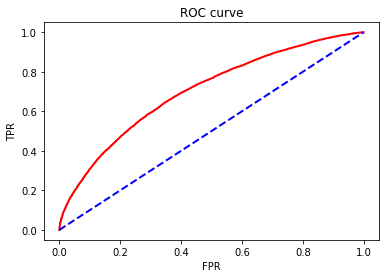

In [35]:
plot_roc(best_grid, x_test, y_test)

## VotingClassifier

In [36]:
from sklearn.ensemble import VotingClassifier

In [37]:
voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', best_grid)],voting='soft')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...mators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [38]:
show_scores(voting_clf, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


ROC-AUC score:  0.6850833952966429


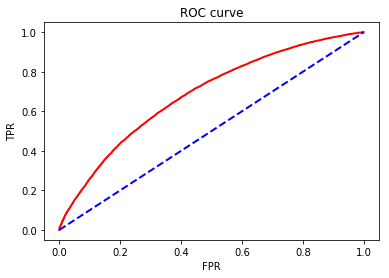

In [ ]:
plot_roc(voting_clf, x_test, y_test)

## Xgboost (Grid search)

[Параметры XGBClassifier](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [8]:
import xgboost as xgb

In [42]:
xgbst = xgb.XGBClassifier(
                           max_depth=3,
                           min_child_weight=3, #Defines the minimum sum of weights of all observations required
                           gamma = 0.25, 
                                    #A node is split only when the resulting split gives a positive 
                                    #reduction in the loss function. Gamma specifies the minimum loss 
                                    #reduction required to make a split.in a child
                           eval_metric = 'auc',                         
                           subsample= 0.52,
                                    #Denotes the fraction of observations to be randomly sampled for each tree
                           colsample_bytree=0.95, #The number of features to consider while searching for the best split
                           reg_alpha= 5,# L1 regularization term on weights
                           reg_lambda=0,# L2 regularization term on weights.
                           learning_rate = 0.01,
                           n_estimators =4000,
                           objective='binary:logistic',
                           
                           verbosity  = 2, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
                          
                           scale_pos_weight=1, #Control the balance of positive and negative weights, useful for unbalanced classes
                           seed=20,
                           random_state= 42,
                           missing=None)

In [ ]:
xgbst.fit(x_train, y_train)

In [ ]:
show_scores(xgbst, x_train, y_train)

In [ ]:
show_scores(xgbst, x_test, y_test)

In [ ]:
plot_roc(xgbst, x_train, y_train)

In [ ]:
plot_roc(xgbst, x_test, y_test)

## Xgboost (Hypetopt)

In [13]:
from sklearn.metrics import r2_score
from hyperopt import tpe, hp, fmin
import xgboost as xgb
from hyperopt.mongoexp import MongoTrials

In [14]:
def func(args):
    loss = 0
    if args['model'] == xgb.XGBClassifier:
        max_depth = args['param']['max_depth']
        min_child_weight = args['param']['min_child_weight']
        gamma = args['param']['gamma']
        subsample = args['param']['subsample']
        colsample_bytree = args['param']['colsample_bytree']
        reg_alpha = args['param']['reg_alpha']
        clf = xgb.XGBClassifier(eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.1,
                               n_estimators=1000,    
                               reg_lambda=0,
                               max_depth = max_depth,
                               min_child_weight =min_child_weight,
                               gamma =  gamma,
                               subsample = subsample,
                               colsample_bytree = colsample_bytree,
                               reg_alpha = reg_alpha)
        clf.fit(x_train,y_train)
        y_pred_train = clf.predict_proba(x_train)
        loss =  roc_auc_score(y_train, y_pred_train[:, 1])
        print("Test Score:",clf.score(x_test,y_test))
        print("Train Score:",clf.score(x_train,y_train))
        print("\n=================")
    return -loss


In [14]:
space = hp.choice('classifier',[
        {
        'model': xgb.XGBClassifier,
        'param': {
        'max_depth' : hp.choice('max_depth',range(3,10,2)),
        'min_child_weight' : hp.choice('min_child_weight', range(1,6,2)),
        'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
        'subsample' : hp.choice('subsample', [i/10.0 for i in range(6,10)]),
        'colsample_bytree'  : hp.choice('colsample_bytree', [i/10.0 for i in range(6,10)]),
        'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 100])  
        }}
        ])
space

In [16]:
# trials = MongoTrials('mongo://localhost:27017/foo_db/jobs',exp_key='exp1')

In [15]:
# best = fmin(func,space,algo=tpe.suggest,max_evals=100)
best = {'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [16]:
best

{'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [25]:
bst = xgb.XGBClassifier(     eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.01,
                               n_estimators=4000,    
                               reg_lambda=0,
                               seed = 20,
                               max_depth = best['max_depth'],
                               min_child_weight = best['min_child_weight'],
                               gamma =  best['gamma'],
                               subsample = 0.52,
                               colsample_bytree = best['colsample_bytree'],
                               reg_alpha = best['reg_alpha'])

In [26]:
bst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=1, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=0, missing=None,
       n_estimators=4000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=3,
       reg_lambda=0, scale_pos_weight=1, seed=20, silent=True,
       subsample=0.52, verbosity=2)

In [34]:
show_scores(bst, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7115789901232025


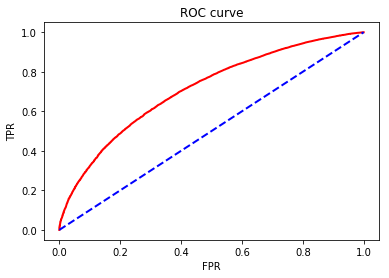

In [35]:
plot_roc(bst, x_test, y_test)

## Catboost

In [56]:
from hyperopt import tpe, hp, fmin
import hyperopt 

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [58]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
int_rate                      140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null object
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
purpose                       140132 non-null object
grade                         140132 non-null object
home_ownership                140132 non-null object
inq_last_6mths                140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
tot_coll_amt                  140132 non-null float64
loan_amnt               

In [59]:
x_train.head()

,annual_inc,int_rate,collections_12_mths_ex_med,initial_list_status,installment,open_acc,total_acc,dti,purpose,grade,home_ownership,inq_last_6mths,pub_rec,revol_bal,revol_util,tot_coll_amt,loan_amnt,application_type,acc_now_delinq
193136,75000.0,13.11,0.0,w,690.97,17.0,42.0,26.85,credit_card,B,MORTGAGE,2.0,0.0,38230.0,87.7,0.0,20475.0,INDIVIDUAL,0.0
27784,73000.0,15.99,0.0,f,421.83,18.0,38.0,16.47,debt_consolidation,D,MORTGAGE,2.0,0.0,9874.0,41.0,0.0,12000.0,INDIVIDUAL,0.0
157132,200000.0,8.90,0.0,f,508.06,14.0,37.0,13.50,debt_consolidation,A,MORTGAGE,2.0,0.0,34550.0,63.0,0.0,16000.0,INDIVIDUAL,0.0
81962,100000.0,15.33,0.0,f,417.94,17.0,36.0,20.48,debt_consolidation,D,MORTGAGE,3.0,0.0,88599.0,60.9,0.0,12000.0,INDIVIDUAL,0.0
161,65000.0,14.16,0.0,w,342.56,14.0,19.0,14.00,debt_consolidation,C,RENT,2.0,0.0,10948.0,43.6,0.0,10000.0,INDIVIDUAL,0.0


In [60]:
categorical_features_indices = x_train.columns[x_train.dtypes == 'object']
categorical_features_indices

Index(['initial_list_status', 'purpose', 'grade', 'home_ownership',
       'application_type'],
      dtype='object')

In [61]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb
import frozendict
# roc_auc_score

In [70]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False,
    'od_type': 'Iter',
    'od_wait': 40
}
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)


In [71]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

In [72]:
show_scores(best_model, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7099626648868074


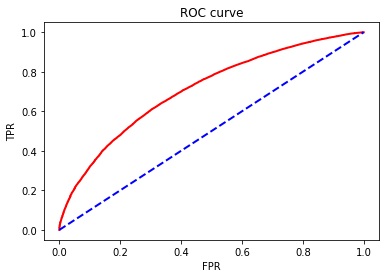

In [73]:
plot_roc(best_model, x_test, y_test)

In [28]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

int_rate: 23.19302265276273
annual_inc: 10.564059542920795
loan_amnt: 9.711976831771299
grade: 8.629637974093532
dti: 8.158009592265008
revol_util: 6.449239897032977
installment: 6.11309861424052
revol_bal: 5.747466503258803
total_acc: 4.802901838186825
open_acc: 4.119144631729223
purpose: 3.001633986398489
home_ownership: 2.2696707232420854
inq_last_6mths: 2.1528367280435163
tot_coll_amt: 1.975184206310043
pub_rec: 1.3365157991190768
initial_list_status: 1.300587232443115
acc_now_delinq: 0.2416933117293601
collections_12_mths_ex_med: 0.23072397825386973
application_type: 0.0025959561987512034


In [48]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 50


In [30]:
const_params = frozendict.frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'custom_metric': ['AUC'],
    'iterations': 100,
    'random_seed':42})

In [31]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'depth': hyper_params['depth'],
            'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    # hyperopt optimizes an objective using `__call__` method (e.g. by doing 
    # `foo(hyper_params)`), so we provide one
    def __call__(self, hyper_params):
        # join hyper-parameters provided by hyperopt with hyper-parameters 
        # provided by the user
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()
        
        # we use cross-validation for objective evaluation, to avoid overfitting
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=42,
            verbose=False)
        
        # scores returns a dictionary with mean and std (per-fold) of metric 
        # value for each cv iteration, we choose minimal value of objective 
        # mean (though it will be better to choose minimal value among all folds)
        # because noise is additive
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [50]:

def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.01, 1.0),
        'depth': hyperopt.hp.randint('depth', 7),
        'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 1, 10)}
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=42))
    return best

def train_best_model(X, y, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization
    dataset = cb.Pool(X, y, cat_features=np.where(X.dtypes != np.float)[0])
    
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params



In [51]:
model, params = train_best_model(
    x_train, y_train, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.4601540416991584, 'depth': 4, 'l2_leaf_reg': 8.493688290834637, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 42}
evaluated score=0.6596485877632808                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.4160029192647806, 'depth': 3, 'l2_leaf_reg': 7.549531688595925, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 42}
evaluated score=0.6535697362924443                                                                                     
evaluated 2 times                                                                                                      
evaluating params={'learning_rate': 0.8390144719

evaluating params={'learning_rate': 0.3330437618473762, 'depth': 2, 'l2_leaf_reg': 6.43044823439896, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 42}
evaluated score=0.643439326719251                                                                                      
evaluated 35 times                                                                                                     
evaluating params={'learning_rate': 0.5411917180868422, 'depth': 4, 'l2_leaf_reg': 2.6565212671416507, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'custom_metric': ['AUC'], 'iterations': 100, 'random_seed': 42}
evaluated score=0.6596485877632808                                                                                     
evaluated 36 times                                                                                                     
evaluating params={'learning_rate': 0.4387671937

In [53]:
params

{'depth': 6,
 'l2_leaf_reg': 2.546844052569046,
 'learning_rate': 0.8142720284737895,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'custom_metric': ['AUC'],
 'iterations': 100,
 'random_seed': 42}

ROC-AUC score:  0.6951312195568873


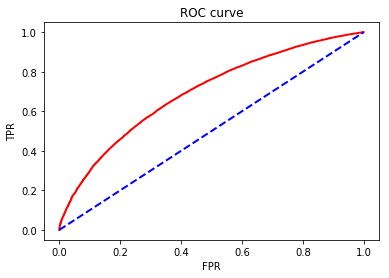

In [54]:
plot_roc(model, x_test, y_test)

In [55]:
show_scores(model, x_test, y_test)

Recall: 0.96
Precision score: 0.80
Accuracy score: 0.78


## LightGBM

In [13]:
import lightgbm as lgb

In [24]:
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 70,
     'max_depth' : 7,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0}

In [25]:
x_train.head()

,acc_now_delinq,annual_inc,application_type,collections_12_mths_ex_med,dti,grade_A,grade_B,grade_C,grade_D,grade_E,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,revol_bal,revol_util,tot_coll_amt,total_acc
193136,0.0,75000.0,True,0.0,26.85,0,1,0,0,0,...,0,0,0,0,0,0,38230.0,87.7,0.0,42.0
27784,0.0,73000.0,True,0.0,16.47,0,0,0,1,0,...,0,0,0,0,0,0,9874.0,41.0,0.0,38.0
157132,0.0,200000.0,True,0.0,13.50,1,0,0,0,0,...,0,0,0,0,0,0,34550.0,63.0,0.0,37.0
81962,0.0,100000.0,True,0.0,20.48,0,0,0,1,0,...,0,0,0,0,0,0,88599.0,60.9,0.0,36.0
161,0.0,65000.0,True,0.0,14.00,0,0,1,0,0,...,0,0,0,0,0,0,10948.0,43.6,0.0,19.0


In [28]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train, free_raw_data=False)

In [32]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index([], dtype='object')

In [ ]:
for col in categorical_features_names: 
    x_train[col] = x_train[col].astype('category')
    x_test[col] = x_test[col].astype('category')

In [20]:
evals_result = {}

In [21]:
num_train, num_feature = x_train.shape
feature_name = ['feature_' + str(col) for col in range(num_feature)]

In [30]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5000,
                valid_sets=[lgb_train, lgb_eval],
               # feature_name=feature_name,              
                categorical_feature= categorical_features_indices,
                evals_result=evals_result,
                verbose_eval=100)

[100]	training's auc: 0.724557	valid_1's auc: 0.703983
[200]	training's auc: 0.731635	valid_1's auc: 0.705662
[300]	training's auc: 0.741478	valid_1's auc: 0.707498
[400]	training's auc: 0.750099	valid_1's auc: 0.708546
[500]	training's auc: 0.759934	valid_1's auc: 0.709186
[600]	training's auc: 0.765676	valid_1's auc: 0.709535
[700]	training's auc: 0.772694	valid_1's auc: 0.709889
[800]	training's auc: 0.778116	valid_1's auc: 0.710141
[900]	training's auc: 0.784195	valid_1's auc: 0.709909
[1000]	training's auc: 0.789573	valid_1's auc: 0.710274
[1100]	training's auc: 0.794999	valid_1's auc: 0.709915
[1200]	training's auc: 0.798573	valid_1's auc: 0.709863
[1300]	training's auc: 0.803335	valid_1's auc: 0.709621
[1400]	training's auc: 0.808596	valid_1's auc: 0.709817
[1500]	training's auc: 0.812394	valid_1's auc: 0.709646
[1600]	training's auc: 0.81673	valid_1's auc: 0.70936
[1700]	training's auc: 0.821871	valid_1's auc: 0.70909
[1800]	training's auc: 0.826704	valid_1's auc: 0.708901
[190

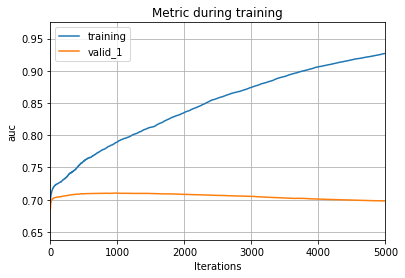

In [31]:
lgb.plot_metric(evals_result, metric='auc')
plt.show()